In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/entity-annotated-corpus/ner.csv
/kaggle/input/entity-annotated-corpus/ner_dataset.csv


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.17.1


In [3]:
print(os.listdir('../input'))


['entity-annotated-corpus']


In [4]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [5]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [6]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

## 1. Dataset Preprocessing

In [7]:
nRowsRead = None # specify 'None' if want to read whole file
# ner_dataset.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('/kaggle/input/entity-annotated-corpus/ner_dataset.csv', delimiter=',', nrows = nRowsRead, encoding='cp1252')
df2.dataframeName = 'ner_dataset.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1048575 rows and 4 columns


In [8]:
df2.head(10)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [9]:
print('Label distribution Training set:')
print(df2['Tag'].value_counts())

Label distribution Training set:
Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64


In [10]:
df2.isnull().sum()


Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

In [11]:
# Looking at the dataset here we will use ffill feature to fill the null values.
#Forward-fills missing values in the Sentence # column.
#Ensures every word is correctly assigned to a sentence.
df=df2.fillna(method='ffill')
df.head()

<ipython-input-11-50e2ff2a5196>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df=df2.fillna(method='ffill')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [12]:
df.isnull().sum()


Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

## 2. Extracting Words and Tags

In [13]:
n_tags=df['Tag'].nunique()
n_tags

17

In [14]:
n_words=df['Word'].nunique()
n_words

35177

In [15]:
words=list(set(df['Word']))
n_words=len(words)
tags=list(set(df['Tag']))

In [16]:
words[10]


'Mattoo'

In [17]:
n_tags=len(tags)
n_tags

17

## 3. Converting data into sentences

In [18]:
class GetSentence(object):
    def __init__(self, data):
        self.n_sentence=1
        self.data=data
        self.empty = False
        function=lambda d:[(w, p, t) for w, p, t in zip(d["Word"].values.tolist(),
                                                        d["POS"].values.tolist(),
                                                        d["Tag"].values.tolist())]
        
        self.group_sent = self.data.groupby("Sentence #").apply(function)
        self.all_sentences = [d for d in self.group_sent] 

In [19]:
get=GetSentence(df)
sentences=get.all_sentences

<ipython-input-18-afd3a31f9fc4>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.group_sent = self.data.groupby("Sentence #").apply(function)


In [20]:
maxl = max([len(s) for s in sentences])
print ('Maximum sequence length in the list of sentences:', maxl)

Maximum sequence length in the list of sentences: 104


## 4. Create word and tag indexing

In [21]:
w_index={w:i for i,w in enumerate(words)}
t_index={t:j for j,t in enumerate(tags)}

## 4. Train word2vec model

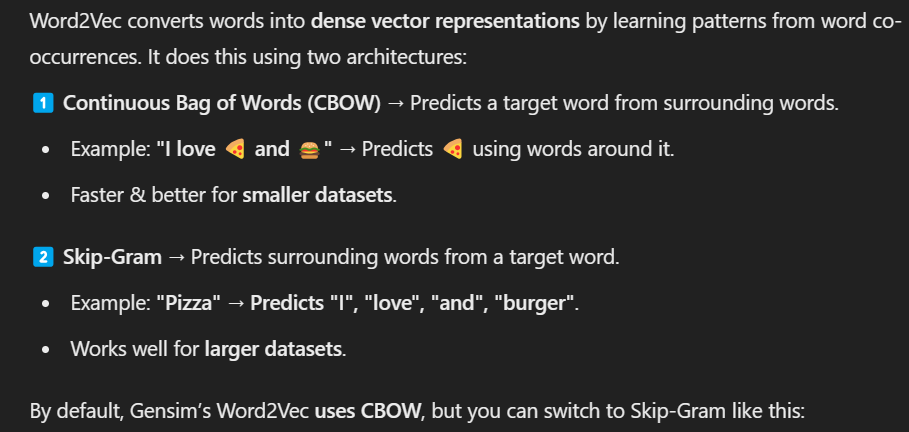

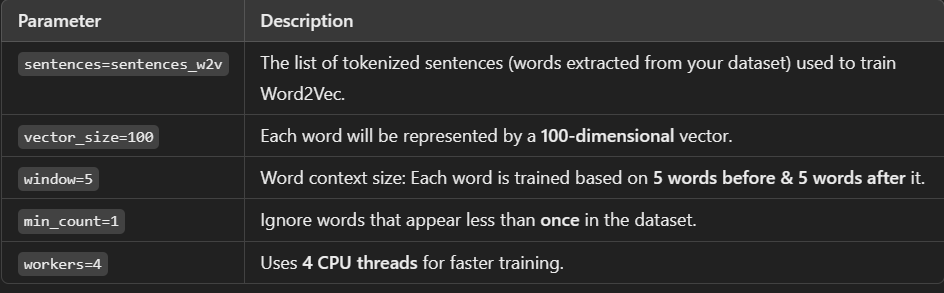
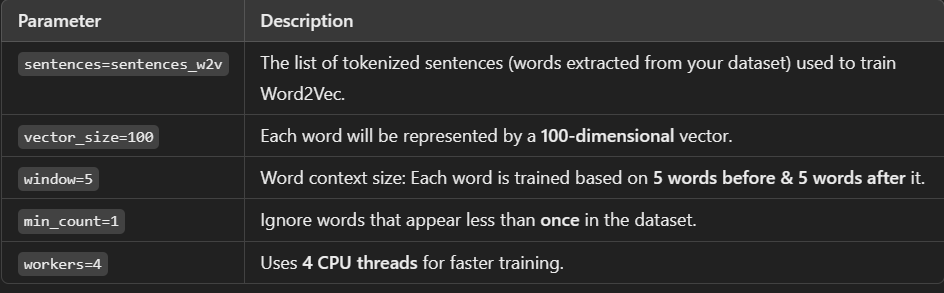

In [22]:
from gensim.models import Word2Vec

# Prepare the dataset for Word2Vec training (list of tokenized sentences)
sentences_w2v = [[w[0] for w in s] for s in sentences]  # Extract words from your dataset

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=sentences_w2v, vector_size=100, window=5, min_count=1, workers=4)

## 5. Convert labels into indixes and apply padding

In [23]:
#Convert labels into indixes and apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [24]:
maxl # This is the length of longest sequence in the list of sentences. So this should be our size of max_padding

104

In [25]:
X=[[w_index[w[0]]for w in s]for s in sentences]
#Converts each word in a sentence into its corresponding index.

In [26]:
X=pad_sequences(maxlen=maxl,padding='post',sequences=X)
#Pads sentences to maxl length using post-padding (adds zeros at the end). Padding to get uniform lengths
X

array([[ 8080, 26580, 16938, ...,     0,     0,     0],
       [ 6894, 18510,  4533, ...,     0,     0,     0],
       [ 6286, 25762, 17817, ...,     0,     0,     0],
       ...,
       [ 6201, 27196, 34841, ...,     0,     0,     0],
       [ 2473, 17756, 21178, ...,     0,     0,     0],
       [11374,  8687, 31284, ...,     0,     0,     0]], dtype=int32)

In [27]:
Y = [[t_index[w[2]] for w in s] for s in sentences]
#Converts NER tags to indexed format.

In [28]:
Y=pad_sequences(maxlen=maxl,padding='post',sequences=Y)
#Pads labels similarly.
Y[1]

array([13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10,
       10, 10,  8, 10, 10, 10, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0], dtype=int32)

In [29]:
#One Hot Encoding
from tensorflow.keras.utils import to_categorical

Y = to_categorical(Y, num_classes=n_tags)

## 6. Splitting train-test split

In [30]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state=42)

In [31]:
print(x_train.shape, y_train.shape)
print()
print(x_test.shape, y_test.shape)

(43163, 104) (43163, 104, 17)

(4796, 104) (4796, 104, 17)


### The embedding matrix is used to map words to their vector representations in a neural network. It acts as a lookup table where each row corresponds to a word's embedding.

It has a shape of (n_words, embedding_dim):
**n_words** → Total number of words in your vocabulary.
**embedding_dim** → The size of each word vector (100 dimensions in this case).
This means each word in our vocabulary gets a row of embedding_dim zeros, which will later be replaced with actual word embeddings.



## 7. Create an Embedding Matrix

In [32]:
import numpy as np

embedding_dim = 100  # If using a pretrained model like Google News, set to 300

# Create an embedding matrix
embedding_matrix = np.zeros((n_words, embedding_dim))  # Initialize a matrix with zeros

for word, i in w_index.items():  
    if word in word2vec_model.wv:  # Check if word exists in Word2Vec vocabulary
        embedding_matrix[i] = word2vec_model.wv[word]  # Assign its word vector
    else:
        embedding_matrix[i] = np.random.uniform(-0.01, 0.01, embedding_dim)  # Assign random vector if word is not found

**Your AttentionLayer implements Luong-style Multiplicative Attention (a.k.a. Dot-Product Attention), which improves sequence modeling by focusing on relevant words in the input sequence.**

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), 
                                 initializer="glorot_uniform", trainable=True)
        self.V = self.add_weight(shape=(input_shape[-1], 1), 
                                 initializer="glorot_uniform", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Apply Luong-style attention
        
        #The attention score is computed by multiplying the input with weight W and applying tanh activation.
        score = tf.nn.tanh(tf.matmul(inputs, self.W))  # Compute scores
        
        #The score is converted into attention weights via softmax, so the sum of weights is 1 (indicating importance).
        attention_weights = tf.nn.softmax(tf.matmul(score, self.V), axis=1)  # Softmax over scores
        
        #The context vector is computed by weighting each time step's output using the attention weights.
        context_vector = attention_weights * inputs  # Weight BiLSTM outputs

        #We sum over the sequence to get a fixed-size context representation (useful for classification)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # Sum over sequence
        
        return context_vector, attention_weights


**The Embedding layer maps each word index to its corresponding vector from the matrix.
If trainable=False, the embeddings won’t be updated during training (useful for pretrained Word2Vec).
If trainable=True, embeddings update to better suit your dataset.**

## 8. BiLSTM Model

In [34]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Bidirectional, Input

# Input Layer
input_layer = Input(shape=(maxl, ))

# Embedding Layer (pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=n_words, 
                            output_dim=embedding_dim, 
                            input_length=maxl, 
                            weights=[embedding_matrix], 
                            trainable=False)(input_layer)
# BiLSTM Layer
lstm_layer = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.1))(embedding_layer)

# Attention Layer (returns two outputs: context_vector and attention_weights)
context_vector, _ = AttentionLayer()(lstm_layer)  # Extract only context_vector

# Fully Connected Layer with Softmax
#output_layer = Dense(n_tags, activation="softmax")(context_vector)  
# Apply Dense layer at every timestep
output_layer = TimeDistributed(Dense(n_tags, activation="softmax"))(lstm_layer)  


# Define Model
model = tf.keras.Model(input_layer, output_layer)

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 104)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 104, 100)            │       3,517,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 104, 300)            │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 104, 17)             │           5,117 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,824,017 (14.59 MB)

 Trainable params: 306,317 (1.17 MB)

 Non-trainable params: 3,517,700 (13.42 MB)

In [35]:
history = model.fit(x_train, np.array(y_train), 
                    validation_split=0.2, 
                    batch_size=32, 
                    epochs=10, 
                    verbose=1)


Epoch 1/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 245s 217ms/step - accuracy: 0.9693 - loss: 0.1805 - val_accuracy: 0.9875 - val_loss: 0.0424
Epoch 2/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 231s 214ms/step - accuracy: 0.9881 - loss: 0.0403 - val_accuracy: 0.9886 - val_loss: 0.0386
Epoch 3/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 231s 214ms/step - accuracy: 0.9890 - loss: 0.0358 - val_accuracy: 0.9896 - val_loss: 0.0338
Epoch 4/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 231s 214ms/step - accuracy: 0.9901 - loss: 0.0320 - val_accuracy: 0.9903 - val_loss: 0.0316
Epoch 5/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 232s 215ms/step - accuracy: 0.9907 - loss: 0.0297 - val_accuracy: 0.9905 - val_loss: 0.0306
Epoch 6/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 231s 214ms/step - accuracy: 0.9911 - loss: 0.0284 - val_accuracy: 0.9907 - val_loss: 0.0303
Epoch 7/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 231s 214ms/step - accuracy: 0.9915 - loss: 0.0269 - val_accuracy: 0.9910 - val_loss: 0.0292
Epoch 8/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 231s 214ms/step - ac

In [36]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9913 - loss: 0.0274
Test Accuracy: 0.9913


In [37]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true=np.argmax(np.array(y_test),axis=-1)[i]
print("{:15} ({:5}): {}".format("Word", "True", "Predicted by our Model"))

print("--"*20)

for w,true,pred in zip(x_test[i],y_true,p[0]):
    print("{:15}{}\t {}".format(words[w-1],tags[true],tags[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Word            (True ): Predicted by our Model
----------------------------------------
incur          O	 O
alienated      O	 O
Barcodes       O	 O
Halabja        O	 O
del            O	 O
148            O	 O
Verhofstadt    O	 O
crept          O	 O
Teshiktosh     O	 O
highly-competitiveB-geo	 B-geo
Tim            O	 O
skiers         O	 B-geo
hospitalizationO	 O
York-based     O	 O
limited        O	 O
defaced        O	 O
signed         O	 O
insurgent-relatedO	 O
Arafura        O	 O
Luay           O	 O
Moussaieff     O	 O
Xinjuan        O	 O
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-nat
Gazprom        B-nat	 B-na